# Lab 3 Vision par ordinateur : Apprentissage profond

Clara MACABIAU et Julien NICOLAS

## Séance 2 : Utilisation des architectures pré-entraînées

Une approche courante et très efficace de l'apprentissage profond consiste à conserver une partie d'un réseau de neurones pré-entrainé. Un réseau pré-entrainé est simplement un réseau entrainé sur une grande base données, généralement sur une tâche de classification d'images à grande échelle.

Si cette base de données utilisée est assez grande et assez générale, alors la hiérarchie des caractéristiques spatiales apprise par le réseau pré-entrainé peut effectivement agir comme un modèle générique de notre monde visuel, et donc ses caractéristiques peuvent s'avérer utiles pour de nombreux problèmes de vision par ordinateur différents, même si ces nouveaux problèmes puissent impliquer des classes complètement différentes.

Dans notre cas, nous considérerons un grand convnet entrainé sur la base de données ImageNet (1,4 million d'images étiquetées et 1000 classes différentes).

Nous utiliserons l'architecture VGG16, développée par Karen Simonyan et Andrew Zisserman en 2014, une architecture convnet simple et largement utilisée.

C'est un modèle un peu plus ancien, loin de l'état de l'art actuel mais nous l'avons choisi car son architecture est facile à comprendre sans introduire de nouveaux concepts.

Le modèle VGG16 est donné dans le framework Keras. Vous pouvez l'importer depuis le module `keras.applications`. Voici la liste quelques modèles pré-entrainé sur ImageNet fournit par Keras:
* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

Il existe deux façons d'exploiter un réseau pré-entrainé :
- Utiliser ce réseau comme un extracteur de caractéristiques.
- Adapter une partie de ce réseau par un petit entrainement. 

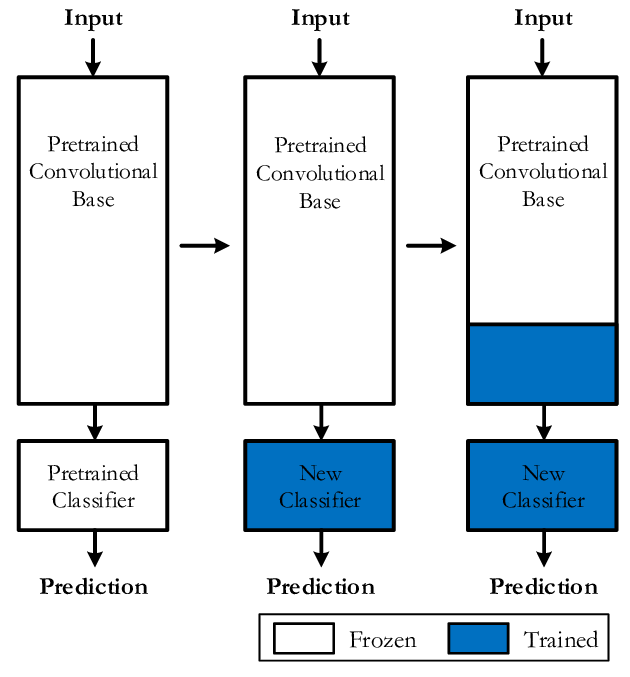
![source] https://www.researchgate.net/figure/TOP-LEVEL-DIAGRAM-OF-TRANSFER-LEARNING-FROM-A-PRE-TRAINED-CNN-MODEL_fig4_333882146

## Partie 1 : Extraction de caractéristiques 

Cette technique consiste à utiliser la partie d'extraction de caractéristiques " `conv_base` " du CNN. 


In [2]:
import tensorflow as tf
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"  #disables GPU 
import matplotlib.pyplot as plt
import numpy as np
tf.__version__

'2.6.0'

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16833672590892909016
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6469084774
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4181117539412420470
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [5]:
conv_base.trainable = False # l'entrainement va pas affecter cette partie
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

La dernière couche est une couche de pooling de forme (4,4,512), c'est à partir de cette couche qu'on va coller un un perceptron multicouche pour la classification.

### Exercice 1 :

1- Ajouter une couche de flatten et un perceptron multicouche (à vous de choisir les hyper-paramétres : nombre de couches, nombre de neurones dans chaque couche, fonction d'activation).

(indice: 
model = models.Sequential()

model.add(conv_base)

model.add(layers.Flatten())
)

2 - Faire le preprocessing des données mini-caltech101 pour que vos images soient preprocess de la même façon qu'elles l'étaient lors de l'entraînement de VGG16

voir https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input, prêter attention à l'input range des images de cette fonction.
   
3- Faire l'entrainement sur  avec un lr=1e-5 pendant 20 époques.
    
4- Tracer les courbes de précision et d'erreur et comparer les résultats obtenus avec les résultats du lab
précedent. 



In [6]:


from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()

model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', input_shape=(7* 7,)))
model.add(layers.Dense(512, activation='relu', input_shape=(7* 7,)))

model.add(layers.Dense(512, activation='relu', input_shape=(7* 7,)))
model.add(layers.Dense(10, activation='softmax'))



In [7]:


import os
import cv2
import numpy as np

def load_data (data_path,img_shape):
    data_dir_list = os.listdir(data_path)
    img_rows=img_shape[0]
    img_cols=img_shape[1]
    num_channel=img_shape[2]


    labels=[]
    data=[]
    len_list_img=0
    num_class=0
    for dataset in data_dir_list:
        img_list=os.listdir(data_path+'/'+ dataset)    
        for img in img_list:
            input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
            input_img=cv2.resize(input_img,(img_rows,img_cols))
            input_img = tf.keras.applications.vgg16.preprocess_input(input_img, data_format=None)
            data.append(input_img)
            labels.append(num_class)
        num_class+=1

    data = np.array(data)
    data = data.astype('float32')
    data /= 255
    labels=np.array(labels)
    print('data shape',data.shape)
    print('labels shape',labels.shape)
    return data, labels



In [9]:


data_path='mini_Caltech101'
img_shape=[224,224,3]
data, labels=load_data (data_path,img_shape)



data shape (500, 224, 224, 3)
labels shape (500,)


In [10]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
num_classes=10
Y = to_categorical(labels, num_classes)
X_train,y_train = shuffle(data,Y, random_state=2)
X_train, X_test, y_train , y_test = train_test_split(X_train,y_train, test_size=0.3, random_state=2)

In [11]:
from tensorflow.keras.optimizers import SGD,RMSprop,Adam

In [12]:

sgd = SGD(learning_rate=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 28,090,698
Trainable params: 13,376,010
Non-trainable params: 14,714,688
___________________________________

In [13]:
n_epoch=20
hist = model.fit(X_train, y_train, batch_size=15, epochs=n_epoch, verbose=1, validation_data=(X_test, y_test))

Epoch 1/20
24/24 [==============================] - 21s 137ms/step - loss: 2.3482 - accuracy: 0.1143 - val_loss: 2.3327 - val_accuracy: 0.1200
Epoch 2/20
24/24 [==============================] - 2s 79ms/step - loss: 2.2876 - accuracy: 0.1457 - val_loss: 2.2775 - val_accuracy: 0.1467
Epoch 3/20
24/24 [==============================] - 2s 79ms/step - loss: 2.2322 - accuracy: 0.2086 - val_loss: 2.2233 - val_accuracy: 0.2067
Epoch 4/20
24/24 [==============================] - 2s 79ms/step - loss: 2.1803 - accuracy: 0.2829 - val_loss: 2.1794 - val_accuracy: 0.3067
Epoch 5/20
24/24 [==============================] - 2s 79ms/step - loss: 2.1340 - accuracy: 0.3514 - val_loss: 2.1361 - val_accuracy: 0.3400
Epoch 6/20
24/24 [==============================] - 2s 79ms/step - loss: 2.0902 - accuracy: 0.4229 - val_loss: 2.0964 - val_accuracy: 0.3733
Epoch 7/20
24/24 [==============================] - 2s 79ms/step - loss: 2.0507 - accuracy: 0.4857 - val_loss: 2.0595 - val_accuracy: 0.4533
Epoch 8/20


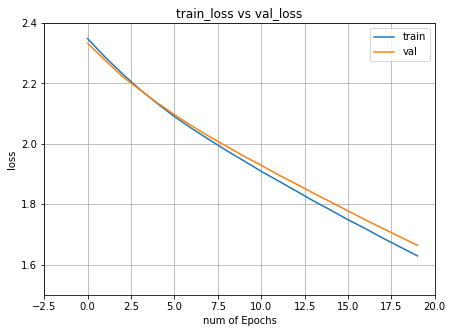

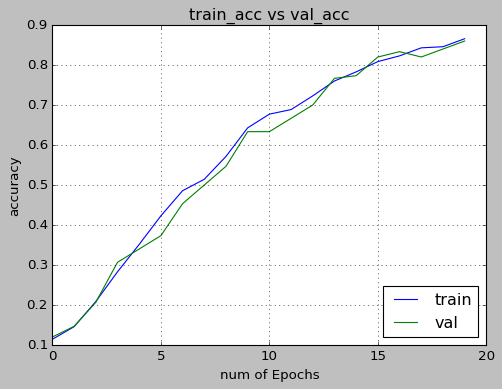

In [14]:
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(n_epoch)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.use(['classic'])

## Partie 2 : Adaptation d'un CNN pré-entraîné   

Dans cette partie, on va faire un petit réglage pour quelques couches de convolution de notre modèle. Cette méthode ajuste légèrement les représentations les plus abstraites du modèle réutilisé, afin de les rendre plus pertinentes pour le problème en question.


In [15]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     


Les étapes suivantes résument cet algorithme :

1- Ajouter un perceptron multicouche.

2- Débloquer quelques couches de la base de convolution. 

3- Faire l'entrainement. 

Par exemple, on va débloquer les couches qui suivent `block4_pool` et laisser les autres bloquées. C'est à dire, les couches `block5_conv1`, `block5_conv2` et `block5_conv3` vont être modifiées lors de l'entrainement.

In [20]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1' or layer.name == 'block5_conv2' or layer.name == 'block5_conv3':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [21]:
model2 = models.Sequential()

model2.add(conv_base)

model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu', input_shape=(7* 7,)))
model2.add(layers.Dense(512, activation='relu', input_shape=(7* 7,)))

model2.add(layers.Dense(512, activation='relu', input_shape=(7* 7,)))
model2.add(layers.Dense(10, activation='softmax'))

In [22]:
n_epoch=20
sgd = SGD(learning_rate=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
model2.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=["accuracy"])

hist = model2.fit(X_train, y_train, batch_size=15, epochs=n_epoch, verbose=1, validation_data=(X_test, y_test))

Epoch 1/20
24/24 [==============================] - 3s 104ms/step - loss: 2.3824 - accuracy: 0.1086 - val_loss: 2.3407 - val_accuracy: 0.1200
Epoch 2/20
24/24 [==============================] - 2s 96ms/step - loss: 2.2926 - accuracy: 0.1457 - val_loss: 2.2657 - val_accuracy: 0.1533
Epoch 3/20
24/24 [==============================] - 2s 93ms/step - loss: 2.2131 - accuracy: 0.2086 - val_loss: 2.2032 - val_accuracy: 0.2067
Epoch 4/20
24/24 [==============================] - 2s 96ms/step - loss: 2.1429 - accuracy: 0.3143 - val_loss: 2.1417 - val_accuracy: 0.3133
Epoch 5/20
24/24 [==============================] - 2s 96ms/step - loss: 2.0791 - accuracy: 0.3800 - val_loss: 2.0871 - val_accuracy: 0.4067
Epoch 6/20
24/24 [==============================] - 2s 97ms/step - loss: 2.0174 - accuracy: 0.5171 - val_loss: 2.0307 - val_accuracy: 0.5067
Epoch 7/20
24/24 [==============================] - 2s 96ms/step - loss: 1.9581 - accuracy: 0.6000 - val_loss: 1.9785 - val_accuracy: 0.5467
Epoch 8/20
2

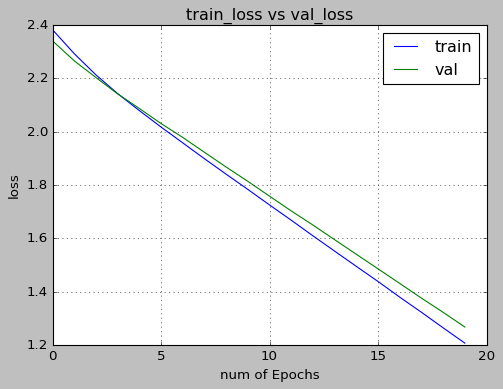

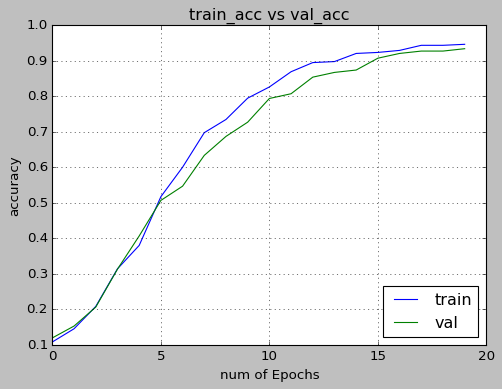

In [23]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(n_epoch)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.use(['classic'])

### Exercice 2:

1- Réaliser l'entrainement du CNN pré-entrainé adapté sur mini-caltech101 (lr=1e-5, 20 époques). 

2- Comparer les résultats obtenus avec les résultats de l'exercice 1. 

3- Expliquer pourquoi on utilise un lr (learning rate) faible.
    

2- Les loss sont plus faibles et la précision est meilleure. C'est parce que le réseau est déjà pré-entraîné.

3- Un learning rate faible permet de réduire les loss davantage. En effet, le learning rate est utilisé dans l'algorithme de descente de gradient pour déterminer le prochain point à utiliser dans l'algorithme. Plus le learning rate est faible, plus les points sont proches et plus on peut explorer un minima local.

## Partie 3 : KNN + CNN pré-entrainé

### Exercice 3 : 
1- Ajouter le VGG entrainé sur ImageNet. (indice : include_top = True)

- Pour la bases de données mini-caltech101 :

2- Extraire le vecteur de caractéristique de l'avant dernière couche. (vecteur de 4096 valeurs)

(indice : 
get_layer_output= K.function([model.input], [model.layers[layer_idx].output])

avec le `num_layer` et le numéro de la couche en considération)


3- Utiliser KNN pour classifier les images (K=1). 

(indice : from sklearn.neighbors import KNeighborsClassifier)

4- Comparer les résultats obtenues avec les résultats de l'exercice 1 et 2. 

In [4]:
from tensorflow.keras.applications import VGG16

In [5]:
vgg = VGG16(weights='imagenet',
                  include_top=True,
                  input_shape=(224, 224, 3))

In [15]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
import tensorflow.keras.backend as K

In [13]:
n_epoch=20
sgd = SGD(learning_rate=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
vgg.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=["accuracy"])
get_layer_output= K.function([vgg.input], [vgg.layers[-2].output])



In [16]:
vgg.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [17]:
vgg.layers[-2].output

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'fc2')>

In [74]:
train_results = []
train_classes = []
val_results = []
val_classes = []

In [75]:
for i in range(len(X_train)):
    train_results.append(get_layer_output(tf.expand_dims(X_train[i], 0, name=None))[0][0])
    train_classes.append(y_train[i])

In [76]:
for i in range(len(X_test)):
    val_results.append(get_layer_output(tf.expand_dims(X_test[i], 0, name=None))[0][0])
    val_classes.append(y_test[i])

In [77]:
from sklearn.neighbors import KNeighborsClassifier

In [78]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(train_results,train_classes)

KNeighborsClassifier(n_neighbors=1)

In [83]:
print(neigh.predict([train_results[1]]))
print(train_classes[1])

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [85]:
neigh.predict([train_results[1]])

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [87]:
train_classes[1] == neigh.predict([train_results[1]])

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]])

In [88]:
accuracy = 0
for i in range(len(val_results)):
    if (neigh.predict([val_results[i]])==val_classes[i]).all():
        accuracy+=1

print(accuracy/len(val_results))        

0.9666666666666667


Nous avons des performances supérieures qu'aux exercices 1 et 2 au détriment d'un temps d'inférence plus élevé.

## Évaluation : 

Exercice 1 : 30%
    
Exercice 2 : 30%
    
Exercice 3 : 40%